***
## Experimentation

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_style('whitegrid')
sns.set_context('talk')

### 5.1

In [16]:
delta = 0.05
def bound1(t, delta, sigma2):
    return np.sqrt(2*np.log(2/delta)/t)

def bound2(t, delta, sigma2):
    return np.sqrt(1+1/(t*sigma2))*np.sqrt((2*np.log(1/delta)+np.log(t*sigma2+1))/t)

In [68]:
ts = np.linspace(1,10000000, 1000).reshape(-1,1)
sigma2s = np.logspace(-6,0,7).reshape(1,-1)

In [69]:
b1 = bound1(ts, delta, sigma2s)
b2 = bound2(ts, delta, sigma2s)
ratio = b2/b1

In [70]:
df = pd.DataFrame({'t': ts.reshape(-1)}, index=None)
df[sigma2s.reshape(-1).astype(str)] = ratio

In [71]:
df.idxmin()

t           0
1e-06     820
1e-05      82
0.0001      8
0.001       1
0.01        1
0.1         1
1.0         0
dtype: int64

In [75]:
df

,t,1e-06,1e-05,0.0001,0.001,0.01,0.1,1.0
0,1.000000e+00,901.165425,284.975026,90.121748,28.513959,9.064112,3.012505,1.346142
1,1.001101e+04,9.059185,3.011023,1.345827,1.118414,1.205053,1.323036,1.435569
2,2.002102e+04,6.442924,2.239780,1.200478,1.134053,1.240448,1.357746,1.467889
3,3.003103e+04,5.290711,1.915832,1.154612,1.149013,1.261378,1.377722,1.486478
4,4.004104e+04,4.607816,1.732024,1.134761,1.161222,1.276217,1.391744,1.499530
...,...,...,...,...,...,...,...,...
995,9.959960e+06,1.118365,1.204796,1.322777,1.435328,1.540153,1.638336,1.730966
996,9.969970e+06,1.118374,1.204847,1.322828,1.435376,1.540197,1.638378,1.731005
997,9.979980e+06,1.118384,1.204897,1.322879,1.435423,1.540241,1.638419,1.731044
998,9.989990e+06,1.118394,1.204947,1.322930,1.435470,1.540285,1.638461,1.731083


In [72]:
df_ = df.melt(id_vars=['t'], value_vars=df.columns[1:], value_name='bound ratio', var_name='sigma')

In [79]:
df_['b2'] = b2.flatten(order='F')

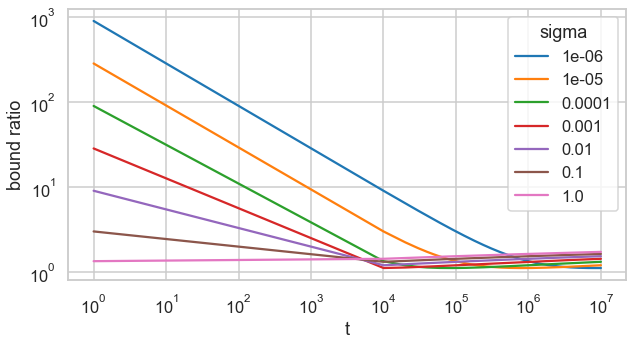

In [74]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_, x='t', y='bound ratio', hue='sigma', ax =ax)
ax.set_yscale('log')
ax.set_xscale('log')

We see that for this delta, the smaller the sigma, the more time it takes for bound (1) to be at its minimum with respect to bound (3). If the absolute value of the mean is about 0.01, to be sure if it is positive or negative we would need a confidence bound of 0.01. The question is, at what time will we have this confidence? Well we want as tight as possible a bound. Given out confidence bound is 0.01, we want to choose sigma such that the all time bound is closest to the single time bound at that confidence. In this case, that looks to me to happen at about sigma2 = 1e-5, leading to just fewer than 1e5 total samples. See the plot below

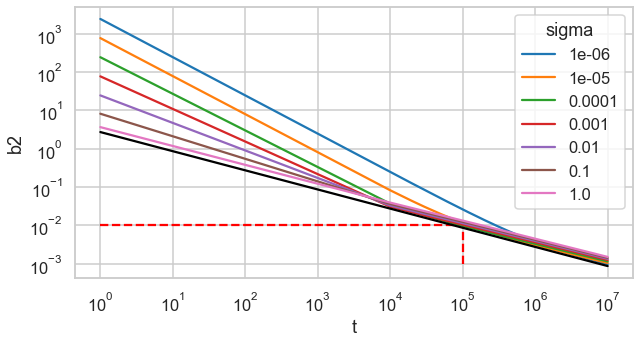

In [400]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_, x='t', y='b2', hue='sigma', ax =ax)
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(ts, b1, c='k')
ax.hlines(y=.01, xmin=1, xmax=1e5, color='r', ls='--')
ax.vlines(x=1e5, ymin=1e-3, ymax=.01, color='r', ls='--')

## 5.2

In [330]:
def sample_X(d: int, a: float, n: int):
        def sample_xi(d: int, a: float):
            sigma2s = [j**(-a) for j in range(1,d+1)]
            return np.array(np.random.normal(0, np.sqrt(sigma2s))).reshape(1,-1)
        return np.concatenate([sample_xi(d, a) for i in range(n)])

In [347]:
class FrankWolfe:
    """
    Attributes
    ----------
    X : (n, d) matrix of arms
    XXT : (n, d, d) matrix of self interaction
    lamb : (n,1) vector of arm distribution
    A : (d, d) matrix of weighted self interactions
    """
    def __init__(self, X: np.ndarray, N: int):
        d = X.shape[1]
        n = X.shape[0]
        
        self.d = d

        self.n = n
        self.N = N
        self.X = X
        self.startup()
        return
    
    def startup(self):
        # pull first 2d arms and set lambda
        pulls = np.random.choice(list(range(self.n)), size=(2*self.d))
        values, counts_ = np.unique(pulls, return_counts=True)
        counts = []
        for i in range(self.n):
            if i in values:
                counts.append(counts_[np.argwhere(values==i)][0][0])
            else:
                counts.append(0)
        self.lamb = (np.array(counts)/(2*self.d)).reshape(-1,1)
        # start time after startup
        self.t = 2*self.d
        # the raw XXT matrix
        xs = []
        for x in self.X:
            xs.append(np.matmul(x.reshape(-1,1), x.reshape(1,-1)))
        self.XXT = np.array(xs)
        return
    
    @property
    def A(self):
        """Function of current lambda"""
        return np.sum(self.lamb.reshape(-1,1,1)*self.XXT, axis=0)
    
    @property
    def D_lamb(self):
        return -np.log(np.linalg.det(self.A))
        
    def update_for_next(self, arm_index):
        """Update lambda and time at the end of the iteration."""
        indicator = np.zeros((self.n,1))
        indicator[arm_index] = 1
        # at this lambda and t are both at their end of previous iteration state, eg t has not been updated
        self.lamb = (self.lamb*self.t + indicator)/(self.t+1)
        self.t += 1
        return
    
    def g_prime_i(self, i):
        """Compute gradient of design equation for one example's lambda"""
        return -np.matmul(np.matmul(self.X[i].reshape(1,-1), np.linalg.inv(self.A)),  self.X[i].reshape(-1,1))
    
    def take_step(self):
        # get the gradient vector
        self.g_prime = np.concatenate([self.g_prime_i(i) for i in range(self.n)])
        It = np.argmin(self.g_prime)
        self.update_for_next(It)
        # print(f'Time {self.t}, pull {It}, D = {self.D_lamb}')
        return 
    
    def run(self):
        while self.t < self.N:
            self.take_step()
        return self.lamb, self.D_lamb
    

In [361]:
# take some replicates
n = np.array([10+2**i for i in range(1,11)])
a = np.array([0.0, .5, 1.0, 2.0])
d = 10
N = 1000

replicates = 3
Ds_means = np.zeros((len(a), len(n)))
Ds_std = np.zeros((len(a), len(n)))

complete = 0
for i, a_ in enumerate(a):
    for j, n_ in enumerate(n):
        D = []
        for k in range(replicates):
            X = sample_X(d, a_, n_)
            alg = FrankWolfe(X, N)
            _, D_ = alg.run()
            D.append(D_)
        Ds_means[i,j] = np.mean(D)
        Ds_std[i,j] = np.std(D)
        complete += 1
        print(f'a = {a_}, n = {n_}. D = {Ds_means[i,j]} ({Ds_std[i,j]}). {complete/Ds_means.size*100}% done.')

a = 0.0, n = 12. D = 8.06257519091605 (2.330491091802562). 2.5% done.
a = 0.0, n = 14. D = 5.524409263052359 (1.9794179132865755). 5.0% done.
a = 0.0, n = 18. D = 3.680728844811585 (1.6102243583540008). 7.5% done.
a = 0.0, n = 26. D = 0.2201054371344974 (0.2206110344052036). 10.0% done.
a = 0.0, n = 42. D = -1.3518502045824643 (0.34857883545810997). 12.5% done.
a = 0.0, n = 74. D = -2.369507612060317 (0.3038460518440702). 15.0% done.
a = 0.0, n = 138. D = -4.050719281855949 (0.21840456635514932). 17.5% done.
a = 0.0, n = 266. D = -5.5880067777245594 (0.0786250778565073). 20.0% done.
a = 0.0, n = 522. D = -6.838935639552545 (0.37513152442019176). 22.5% done.
a = 0.0, n = 1034. D = -7.700344898358111 (0.3928162663594443). 25.0% done.
a = 0.5, n = 12. D = 14.70006416591855 (1.649935120496207). 27.500000000000004% done.
a = 0.5, n = 14. D = 12.225586626734268 (0.9497121976855598). 30.0% done.
a = 0.5, n = 18. D = 9.771008624790296 (0.7572553151136145). 32.5% done.
a = 0.5, n = 26. D = 8.27

In [362]:
np.save('a.npy', a)
np.save('n.npy', n)
np.save('D_means.npy', Ds_means)
np.save('D_std.npy', Ds_std)

In [370]:
dfs = []
for i, a_ in enumerate(a):
    df = pd.DataFrame(data=n, columns=['n'])
    df['mean'] = Ds_means[i]
    df['std'] = Ds_std[i]
    df['a'] = a_
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

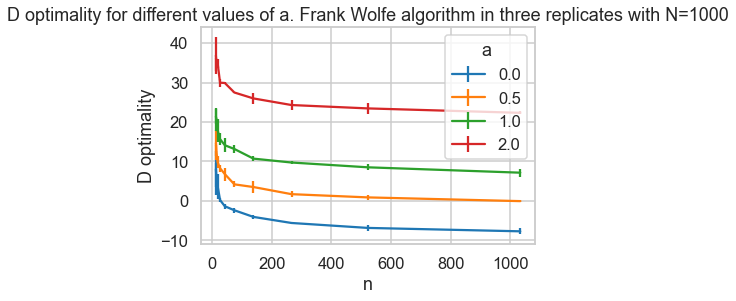

In [394]:
fig, ax = plt.subplots()
for i, a_ in enumerate(a):
    ax.errorbar(n, Ds_means[i], yerr=2*Ds_std[i], label=a_)
ax.set_xlabel('n')
ax.set_ylabel('D optimality')
ax.set_title('D optimality for different values of a. Frank Wolfe algorithm in three replicates with N=1000')
plt.legend(title='a')

## 5.3

1. The desired model is to minimize the maximum error over all example sets. This corresponds to E optimality, as such one would generate an E optimal $\lambda$ and sample from that. In this sense, we can guarantee that the expected value of the maximum example error will be minimized, however we can make no promises about the random quantity. We could arrive at the E optimal $\lambda$ by using the Franke wolfe implimented above, except that the criteria for picking the next arm would have to be changed to correspond to the minumum of the partial derivative of E optimal design equation instead of the D optimal one.

In [402]:
import numpy as np
n =300
X = np . concatenate ( ( np . linspace (0 ,1 ,50) , 0.25+ 0.01* np . random . randn (250) ) , 0)
X = np . sort (X)

K = np . zeros ((n ,n))
for i in range ( n):
    for j in range ( n):
        K[i ,j] = 1+ min (X[i] ,X[j ])
e , v = np . linalg . eigh (K ) # eigenvalues are increasing in order
d = 30
Phi = np . real (v @ np . diag ( np . sqrt ( np . abs (e ))) ) [: ,(n -d ) ::]

In [406]:
Phi.shape

(300, 30)

In [410]:
def f(x):
    return -x**2 + x*np.cos(8*x)+np.sin(15*x)

f_star = f(X)
theta = np.linalg.lstsq(Phi, f_star, rcond=None)[0]
f_hat = Phi @ theta

In [430]:
def observe(idx):
    return f(X[idx]) + np.random.randn(len(idx))

def sample_and_estimate(X, lbda, tau):
    n, d = X.shape
    reg = 1e-6
    idx = np.random.choice(np.arange(n), size=tau, p=lbda)
    y = observe(idx)
    print(X.shape)
    print(y.shape)
    
    XtX = X[idx].T @ X[idx]
    XtY = X[idx].T @ y
    print(X[idx].shape)
    print(XtX.shape)
    print(XtY.shape)
    
    theta = np.linalg.lstsq(XtX + reg*np.eye(d), XtY, rcond=None)[0]
    print(theta.shape)
    y_hat = Phi @ theta
    print(y_hat.shape)
    return y_hat, XtX

In [416]:
frank = FrankWolfe(Phi, 1000)
lmbda, D = frank.run()

In [431]:
lbda = lmbda.reshape(-1)
f_G_Phi, A = sample_and_estimate(Phi, lbda, 1000)

(300, 30)
(1000,)
(1000, 30)
(30, 30)
(30,)
(30,)
(300,)


In [432]:
lbda = np . ones (n)/ n
f_unif_Phi , A = sample_and_estimate( Phi , lbda , 1000)
conf_unif = np . sqrt ( np . sum ( Phi @ np . linalg . inv (A) * Phi , axis =1) )

(300, 30)
(1000,)
(1000, 30)
(30, 30)
(30,)
(30,)
(300,)
